## Introduction
This is adjust from the `test2.ipynb`, which is used to proof that the specific column of the Pearson's covariance matrix can be calculated column by column from $x$. 

#### Formula
Assume $X$ is an centered O/E matrix, $std$ is the standard deviation of $X$, $n$ is the length of $X[0]$.

* Pearson matrix: $A = \frac{1}{std} \frac{1}{n}X X^{T}$
* Covariance matrix: $\frac{1}{n}A A^{T}$
* The Covariance matrix of the Pearson matrix: $\frac{1}{n} (\frac{1}{std} \frac{1}{n}X X^{T} - C)(\frac{1}{std} \frac{1}{n}X X^{T}  - C)^{T}$, where the $C$ is the mean of the Pearson matrix.

In [25]:
import numpy as np
from hicpep import peptools
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)
np.set_printoptions(threshold=10)
# np.random.seed(20)

def flip_tracks(track1_np: np.ndarray, track2_np: np.ndarray):
    if np.corrcoef(track1_np[~np.isnan(track1_np)], track2_np[~np.isnan(track2_np)])[0][1] < 0:
        track2_np = -track2_np

    return track1_np, track2_np

### Simulated Sample

In [26]:
def generate_X(n:int):
    # Create a nxn array with random positive values
    matrix_np = np.abs(np.random.randn(n, n))  # Use absolute values for positive entries
    # Make the array symmetric
    matrix_np = matrix_np + matrix_np.T
    matrix_np = matrix_np.astype("float64") # Sparse
    return matrix_np 

X = generate_X(n=15) # Generate a n*n simulated O/E matrix.
X -= X.mean(axis=1, keepdims=True) # Center the X.
n = len(X[0])
std = np.std(X, axis=1)
std = np.array([std]).flatten()

corr = np.corrcoef(X)
corr -= corr.mean(axis=1, keepdims=True)
corr_cov = np.cov(corr, bias=True)

# Carry out the PCA on the Pearson matrix.
pca = PCA(n_components=1)
pca.fit(np.corrcoef(X))
pc1_np = pca.components_[0]

print(corr_cov, '\n')
print(f"Explained variance ratio of the PC1: {pca.explained_variance_ratio_[0]}")

[[ 0.1024  -0.04631 -0.01363 ... -0.03986 -0.00846  0.00946]
 [-0.04631  0.13183 -0.01831 ...  0.08397 -0.04887 -0.03983]
 [-0.01363 -0.01831  0.08056 ... -0.03899  0.01398 -0.00219]
 ...
 [-0.03986  0.08397 -0.03899 ...  0.16066 -0.07434 -0.09803]
 [-0.00846 -0.04887  0.01398 ... -0.07434  0.10075  0.03259]
 [ 0.00946 -0.03983 -0.00219 ... -0.09803  0.03259  0.12513]] 

Explained variance ratio of the PC1: 0.453037282720738


In [27]:
print("std", '\n')
print(std)
print(std.shape)

std 

[0.87376 1.04459 0.74213 ... 0.5033  0.70871 0.75547]
(15,)


Plot the Pearson matrix.

Text(0.5, 1.0, 'This is the heatmap of the Pearson matrix')

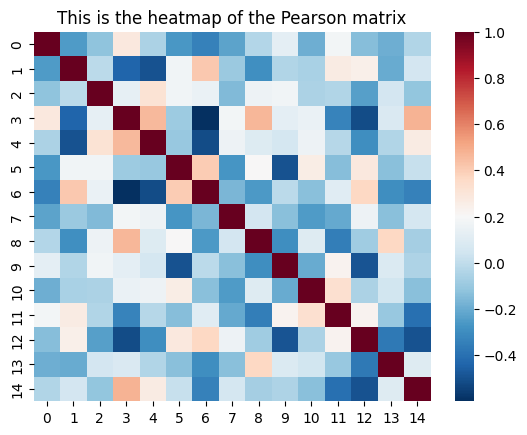

In [28]:
ax = plt.axes()
sns.heatmap(np.corrcoef(X), ax=ax, cmap="RdBu_r")
ax.set_title(f'This is the heatmap of the Pearson matrix')

In [29]:
index_s = 0 # The target column (or row) in the Pearson's covariance matrix.
corr_s = (X @ X[index_s].T / (std[index_s] * std)) / n # The target column (or row) in the Pearson matrix.
corr_s -= corr_s.mean()
print(corr_s, '\n')
print(corr_s.shape)

[ 1.01779 -0.23393 -0.10177 ... -0.12032 -0.17429 -0.02341] 

(15,)


In [30]:
cov_s = []

for i in range(n):
    corr_i = (X @ X[i].T / (std[i] * std)) / n # Calculate the other columns in the Pearson matrix one by one. 
    corr_i -= corr_i.mean()
    entry = corr_i @ corr_s / n # Calculate each entry of the target column (or row) in the Pearson's covariance matrix.
    cov_s.append(entry)

cov_s = np.array(cov_s)

# Finally, these two tracks should be exactly the same.
print(corr_cov[index_s], '\n')
print(cov_s, '\n')

[ 0.1024  -0.04631 -0.01363 ... -0.03986 -0.00846  0.00946] 

[ 0.1024  -0.04631 -0.01363 ... -0.03986 -0.00846  0.00946] 



### Find the best track and plot

In [31]:
max = 0
est_np = np.array([]) 

for k in range(n):
    index_s = k # The target column (or row) in the Pearson's covariance matrix.
    corr_s = (X @ X[index_s].T / (std[index_s] * std)) / n # The target column (or row) in the Pearson matrix.
    corr_s -= corr_s.mean()
    cov_s = []

    for i in range(n):
        corr_i = (X @ X[i].T / (std[i] * std)) / n # Calculate the other columns in the Pearson matrix one by one. 
        corr_i -= corr_i.mean()
        entry = corr_i @ corr_s / n # Calculate each entry of the target column (or row) in the Pearson's covariance matrix.
        cov_s.append(entry)

    cov_s = np.array(cov_s)
    track_sum_abs = np.sum(np.abs(cov_s))
    if track_sum_abs > max:
        max = track_sum_abs
        est_np = cov_s

similar_rate: 1.0


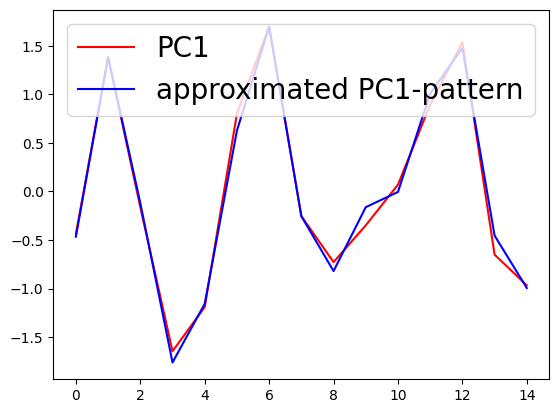

In [32]:
pc1_np, est_np = flip_tracks(track1_np=pc1_np, track2_np=est_np)
similarity_info = peptools.calc_similarity(track1_np=pc1_np, track2_np=est_np)
total_entry_num = similarity_info["total_entry_num"]
valid_entry_num = similarity_info["valid_entry_num"]
similar_num = similarity_info["similar_num"]
similar_rate = similarity_info["similar_rate"]

print(f"similar_rate: {similar_rate}")

# Z-score Normalization
est_np_norm = (est_np - np.mean(est_np)) / np.std(est_np)
pc1_np_norm = (pc1_np - np.mean(pc1_np)) / np.std(pc1_np)

plt.plot(pc1_np_norm, c='r')
plt.plot(est_np_norm, c='b')
plt.legend(["PC1", "Estimated PC1-pattern"], fontsize="20", loc ="upper left")